<a href="https://colab.research.google.com/github/Peter-ZZZZZ/ALP_ComSc/blob/main/presentation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
!pip install -U tensorflow-quantum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.0
    Uninstalling sympy-1.13.0:
      Successfully uninstalled sympy-1.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_sy

In [3]:
!pip install -U tensorflow-quantum

In [4]:
!pip install -U tfq-nightly

ERROR: Could not find a version that satisfies the requirement tfq-nightly (from versions: none)
ERROR: No matching distribution found for tfq-nightly


In [5]:
!pip install tensorflow-quantum==0.7.3

In [6]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [7]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [8]:
a, b = sympy.symbols('a b')

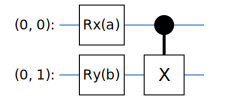

In [9]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(q0, q1))

SVGCircuit(circuit)

In [10]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [11]:
z0 = cirq.Z(q0)

qubit_map={q0: 0, q1: 1}

z0.expectation_from_state_vector(output_state_vector, qubit_map).real

0.8775825500488281

In [12]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

In [13]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [14]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [15]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=float)
print(batch_vals)

[[5.45863939 5.51994587]
 [4.00982196 5.41233755]
 [2.06822466 3.08977542]
 [4.90104964 0.32644372]
 [6.07011703 4.23233645]]


In [16]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.67889041]
 [-0.6461789 ]
 [-0.47716713]
 [ 0.18754354]
 [ 0.97738659]]


In [17]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.678892  ],
       [-0.6461778 ],
       [-0.47716787],
       [ 0.18754536],
       [ 0.9773871 ]], dtype=float32)>

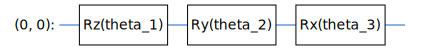

In [18]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [19]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [20]:
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.66754884,  0.7333592 , -1.1244208 ]], dtype=float32)

In [21]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string`
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [22]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

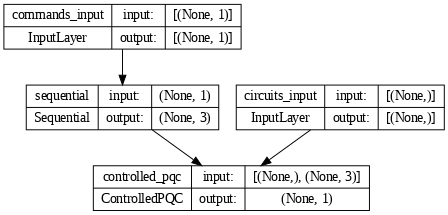

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [24]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [25]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

datapoint_circuits.shape

TensorShape([2])

In [26]:
model([datapoint_circuits, commands]).numpy()

array([[ 0.5387796 ],
       [-0.07505947]], dtype=float32)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

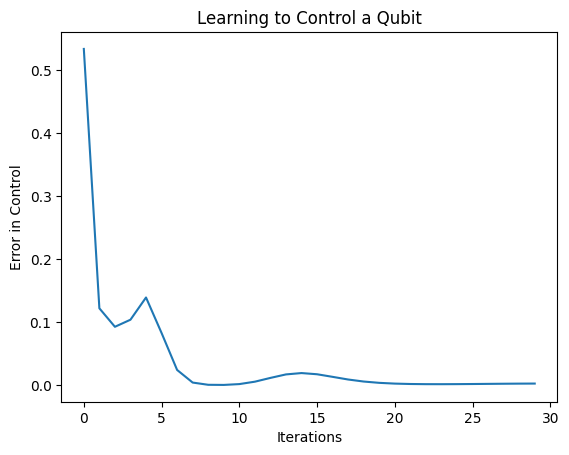

In [28]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [29]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expt = cirq.Z(qubit).expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expt}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [-0.5034663   1.2196977   0.23465121]
Which gives an actual expectation of: 0.956283688545227

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-1.6151955   0.08194229 -2.4639845 ]
Which gives an actual expectation of: -0.9463497996330261



In [30]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.9562834],
       [-0.9463488]], dtype=float32)>

In [31]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string`
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [32]:
# Define classical NN.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [33]:
dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

In [34]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    verbose=1)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 2.5609
Epoch 2/30
1/1 [==============================] - 0s 50ms/step - loss: 2.0051
Epoch 3/30
1/1 [==============================] - 0s 43ms/step - loss: 1.6274
Epoch 4/30
1/1 [==============================] - 0s 38ms/step - loss: 1.3239
Epoch 5/30
1/1 [==============================] - 0s 31ms/step - loss: 1.0171
Epoch 6/30
1/1 [==============================] - 0s 37ms/step - loss: 0.7042
Epoch 7/30
1/1 [==============================] - 0s 31ms/step - loss: 0.4214
Epoch 8/30
1/1 [==============================] - 0s 29ms/step - loss: 0.2134
Epoch 9/30
1/1 [==============================] - 0s 33ms/step - loss: 0.0971
Epoch 10/30
1/1 [==============================] - 0s 47ms/step - loss: 0.0505
Epoch 11/30
1/1 [==============================] - 0s 56ms/step - loss: 0.0409
Epoch 12/30
1/1 [==============================] - 0s 33ms/step - loss: 0.0499
Epoch 13/30
1/1 [==============================] - 0s 49ms/step

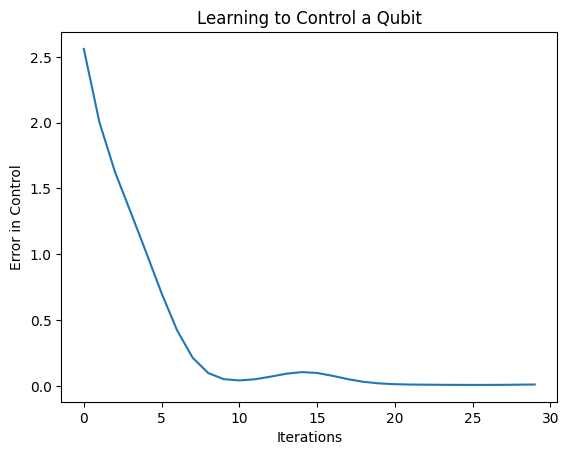

In [36]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [37]:
controller.predict(np.array([0,1]))

1/1 [==============================] - 0s 461ms/step


array([[-0.44890338,  2.5960479 , -0.13862738],
       [-1.9858656 , -1.4194405 , -2.1829987 ]], dtype=float32)

In [38]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11490434/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [39]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [40]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


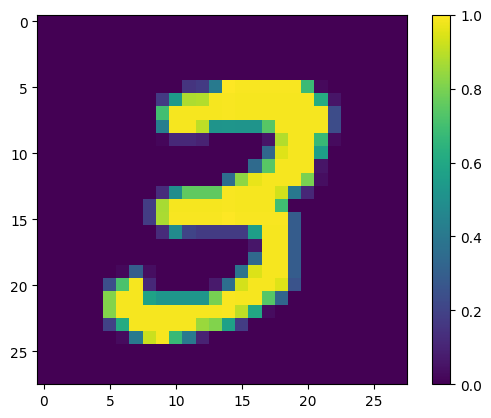

In [41]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [42]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


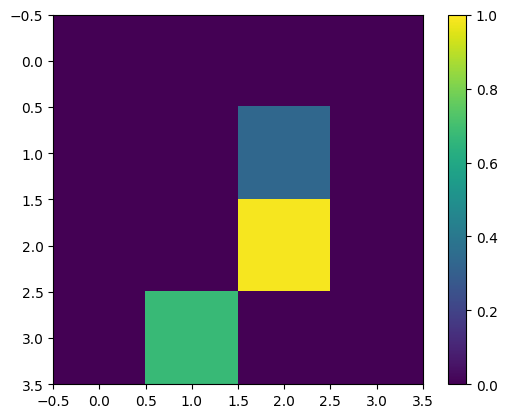

In [43]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [44]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

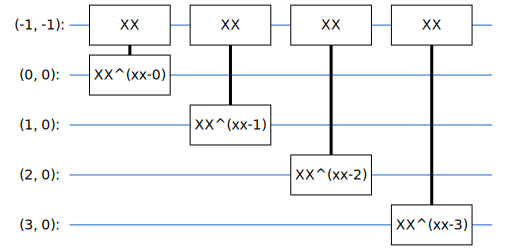

In [45]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [46]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [47]:
model_circuit, model_readout = create_quantum_model()


In [48]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [49]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

4422102/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [50]:
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [51]:
x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


True


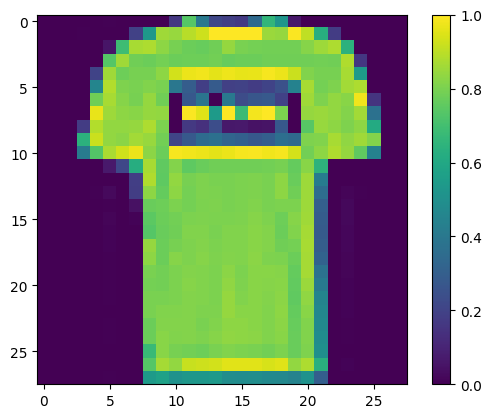

In [52]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

In [53]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

In [54]:
DATASET_DIM = 10
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))

New datapoint dimension: 10


In [55]:
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

In [56]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 200


In [57]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])

  return wall_circuit

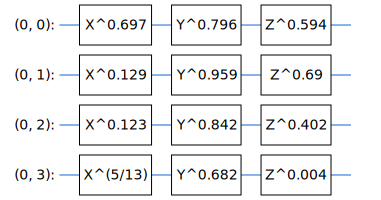

In [58]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3))))

In [59]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

Symbols found in circuit:[ref_0]


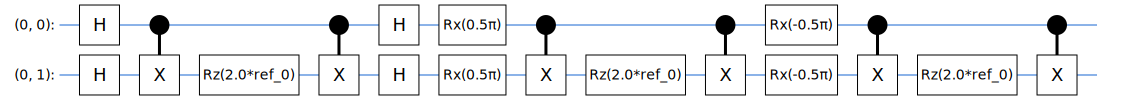

In [60]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

In [61]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

In [62]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

In [63]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

In [64]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


In [65]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [66]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[-0.02067866  0.00876432 -0.00573429 ...  0.05460539 -0.00305845
   0.02413424]
 [-0.02084124  0.02154154 -0.03669118 ... -0.0008865   0.7254114
   0.02597395]
 [-0.02814782 -0.00432722 -0.00171175 ... -0.68640524  0.00479524
   0.02860868]
 ...
 [ 0.05720693 -0.00729139 -0.02187859 ... -0.02162954  0.01039701
   0.04424389]
 [ 0.06850027 -0.01503295  0.01003954 ...  0.07831077  0.03652466
   0.04573527]
 [ 0.05964617 -0.00398245 -0.00151708 ...  0.00615668 -0.00240714
   0.03851489]], shape=(1200, 1200), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[ 3.8356818e-02  2.8347293e-02 -1.1697864e-02 ... -4.0755421e-02
   2.0624822e-02  3.2069720e-02]
 [-4.0181600e-02  8.8809701e-03 -1.3882567e-02 ... -7.6112538e-03
   7.1638334e-01  2.8819481e-02]
 [-1.6671857e-02  1.3503703e-02 -3.6638588e-02 ...  4.2131193e-02
  -3.7604037e-03  2.1954076e-02]
 ...
 [-3.0156480e-02 -1.6716314e-02 -1.6033923e-02 ...  2.1481956e-03
  -5.830

In [67]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [68]:
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_train_new, y_test_new = y_relabel[:N_TRAIN], y_relabel[N_TRAIN:]

In [69]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                1088      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1633 (6.38 KB)
Trainable params: 1633 (6.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))

In [70]:
#docs_infra: no_execute
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                352       
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 897 (3.50 KB)
Trainable params: 897 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
#docs_infra: no_execute
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(x_test, y_test_new))

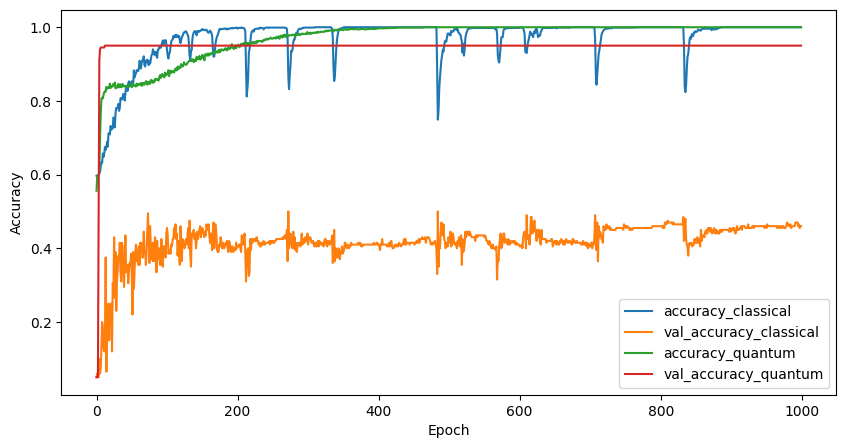

In [74]:
#docs_infra: no_execute
plt.figure(figsize=(10,5))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()